In [1]:
import numpy
import qubit_matmul
import scipy.sparse
from matplotlib import pyplot
import os

# Make XXZ model

In [2]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_ladder(l,jrung,jrail,hz):
    terms = []
    
    hrung = jrung*(spm + smp + szz)
    hrail = jrail*(spm + smp + szz)
    hz = sz * hz
    
    for i in range(l//2):
        a = 2*i
        b = 2*i + 1
        c = 2*(i+1) % (l//2)
        d = (2*(i+1) + 1) % (l//2)
        print(a,b,c,d)
        
        terms.append(qubit_matmul.TensorMatf64([a, b], hrung.flatten()))
        terms.append(qubit_matmul.TensorMatf64([a, c], hrail.flatten()))
        terms.append(qubit_matmul.TensorMatf64([b, d], hrail.flatten()))
        
    for i in range(l):
        terms.append(qubit_matmul.TensorMatf64([i], hz.flatten()))
        
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc


def make_xxz_ham(l,jz,hz=0.0):
    terms = []
    
    interaction = spm + smp + jz*szz
    hz = sz * hz
    
    for i in range(l):
        a = i
        b = (i+1)%l
        
        terms.append(qubit_matmul.TensorMatf64([a, b], interaction.flatten()))
        terms.append(qubit_matmul.TensorMatf64([i], hz.flatten()))
        
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [3]:
l = 10
ham = make_xxz_ham(l,-0.5)

ham = ham.get_sparse(l)

vals, vecs = scipy.sparse.linalg.eigsh(ham,k=1)

gs = vecs[:,0]

In [4]:
# Check half filling
data = []
for i,x in enumerate(gs):
    if abs(x) > 1e-10:
        data.append(bin(i)[2:].zfill(l).count('1'))
assert(all(map(lambda x: x==l//2, data)))

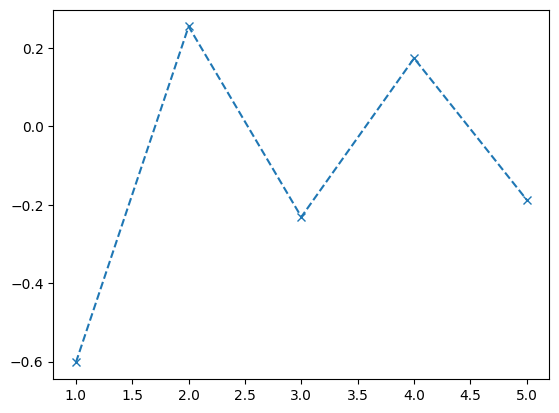

In [5]:
data = []
dist = numpy.arange(1,l//2+1)
for i in dist:
    corr_check = make_zz(0,i).get_sparse(l)
    data.append(gs @ (corr_check @ gs))

pyplot.plot(dist,data,'x--')

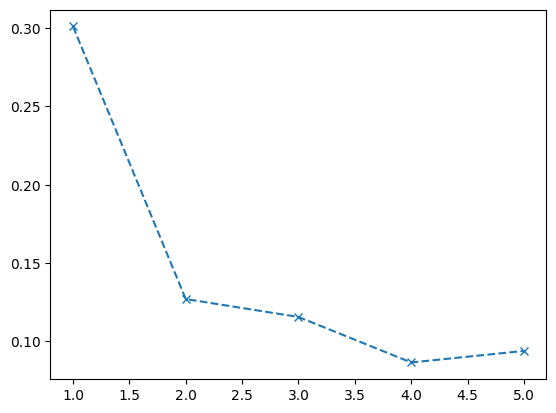

In [6]:
datah = []
disth = numpy.arange(1,l//2 + 1)

for i in disth:
    corr_check = make_pm(0,i).get_sparse(l)
    datah.append(gs @ (corr_check @ gs))

pyplot.plot(disth,datah,'x--')

# Reconstruction

In [7]:
import shadow_reconstruction
import qutip as qt

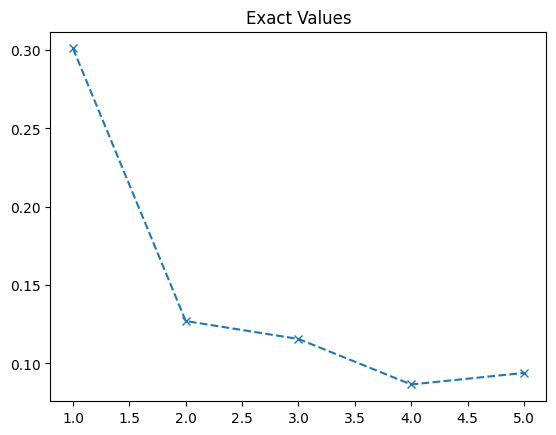

In [12]:
rho = shadow_reconstruction.DensityMatrix.new_pure_dense(gs.astype(numpy.complex128))

datah = []
disth = numpy.arange(1,l//2 + 1)

for i in disth:
    string = ['I'] * l
    string[0] = '+'
    string[i] = '-'
    string = ''.join(string)
    x = rho.expectation_string(string)
    
    datah.append(x.real)

pyplot.title('Exact Values')
pyplot.plot(disth,datah,'x--')
pyplot.show()

In [17]:
exp = shadow_reconstruction.Experiment(l)
samples = exp.sample(rho, 100_000)

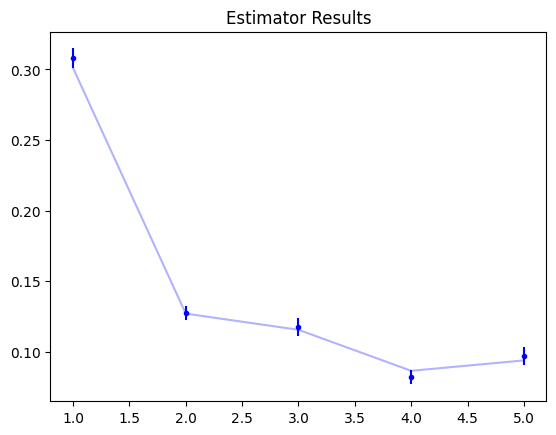

In [19]:
recon = shadow_reconstruction.Reconstruction(True)

new_datah = []
new_datah_std = []

for i in disth:
    string = ['I'] * l
    string[0] = '+'
    string[i] = '-'
    string = ''.join(string)
    x = recon.estimate_string_for_each_sample(string, samples)
    
    new_datah.append(x.real.mean())
    new_datah_std.append(x.real.std()/numpy.sqrt(len(x)))
    
pyplot.title('Estimator Results')
pyplot.errorbar(disth,new_datah,yerr=new_datah_std,fmt='.',c='blue')
pyplot.plot(disth,datah,'-',c='blue',alpha=0.3)
pyplot.show()